In [4]:
import itertools
import numpy as np
import cv2
import matplotlib.pyplot as plt

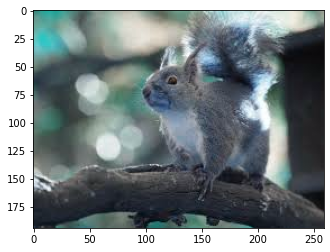

In [5]:
org_img = cv2.imread("./drive/My Drive/ColabNotebooks/PRML/8章/1.jpg")
assert org_img is not None
plt.imshow(org_img)
plt.show()

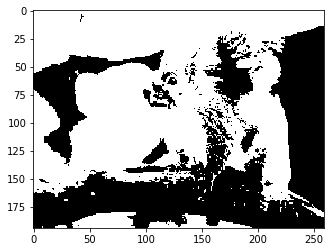

In [6]:
gray_img = cv2.cvtColor(org_img, cv2.COLOR_RGB2GRAY)
ret, binary_img = cv2.threshold(gray_img, 80, 255, cv2.THRESH_BINARY)
binary_img = np.where(binary_img == 255, 1, binary_img)
binary_img = np.where(binary_img == 0, -1, binary_img)
plt.imshow(binary_img, cmap="gray", interpolation="none")
plt.show()

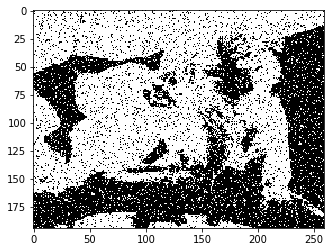

In [9]:
def noise(pixel):
  if pixel == 1:
    pixel = np.random.choice([-1,1], p=[0.1,0.9])
  else:
    pixel = np.random.choice([-1,1], p=[0.9, 0.1])
  return pixel
noise_img = np.vectorize(noise)(binary_img)
plt.imshow(noise_img, cmap="gray", interpolation="none")
plt.show()

# Structure
## Class Node
1.   add_neighbor
2.   get_neighbor
1.   init_message
2.   marginalize
1.   send_message_to
2.   likelihood

## Class MarkovRandomField
1.   add_node
2.   get_node
1.   add_edge
2.   sum_product











In [68]:
from functools import reduce
class Node(object):
  def __init__(self):
    self.neightbors = []
    self.messages = {}
    self.prob = None

    self.alpha = 10.
    self.beta = 5.

  def add_neighbor(self, node):
    """
    add neighboring node
    :param node: Node,
    """
    self.neightbors.append(node)

  def get_neighbors(self):
    """
    get neighboring node
    :return node: list of Node objects
    """
    return self.neightbors

  def init_message(self):
    """
    initialize massage from neighbor nodes
    """
    for neighbor in self.neightbors:
      self.messages[neighbor] = np.ones(shape=(2,)) * 0.5
    
  def send_message_to(self, node):
    """
    calculate massage to corresponding node
    
    :param node: node to send massage
    """
    message_from_neighbors = reduce(lambda x,y: x*y, self.messages.values()) / self.messages[node]
    F = np.exp( self.beta * (2 * np.eye(2) - 1))
    message = F.dot(message_from_neighbors)
    node.messages[self] = message / message.sum() # 正規化

  def marginalize(self):
    """
    calculate probablity
    :param node: Node, node to send computed message
    :return massage: np.narray, size=(2,) 
    """
    prob = reduce(lambda x,y: x*y, self.messages.values())
    self.prob = prob / prob.sum()

  def likelihood(self, value):
    """
    caluculate likelihood via observation, which is message to this node
    :param value : int, value = {-1,1}
    """
    assert (value == -1) or (value == 1)
    message = np.exp(self.alpha * np.array([-value, value]))
    self.messages[self] = message / message.sum()
  

In [73]:
class MarkovRandomField(object):
  def __init__(self):
    self.nodes = {}

  def add_node(self, location):
    """
    add a new node at the location
    :param location: tuple, key to access location
    """
    self.nodes[location] = Node()

  def get_node(self, location):
    """
    get node at the location
    :param location: tuple, key to access location
    """
    return self.nodes[location]

  def add_edge(self, key1, key2):
    """
    add a edge between nodes corresponding to key1 and key2
    :param key1, key2: tuple, key to nodes
    """
    self.nodes[key1].add_neighbor(self.nodes[key2])
    self.nodes[key2].add_neighbor(self.nodes[key1])

  def sum_product_algorithm(self, iter_max=10):
    """
    Perform sum_product algorithm
    1. initialize message
    2. send message from each node to neighbor nodes
    3, calculate probablities using those massage
    
    :param iter_max: int, num of maximum iteration
    """
    for node in self.nodes.values():
      node.init_message()

    for i in range(iter_max):
      print(i)
      for node in self.nodes.values():
        for neighbor in node.get_neighbors():
          node.send_message_to(neighbor)

    for node in self.nodes.values():
      node.marginalize()

def denoise(img, n_iter=20):
  mrf = MarkovRandomField()
  len_x, len_y = img.shape
  X = range(len_x)
  Y = range(len_y)

  for location in itertools.product(X,Y):
    mrf.add_node(location)

  for x, y in itertools.product(X,Y):
    for dx, dy in itertools.permutations(range(2), 2):
      try:
        mrf.add_edge((x,y), (x+dx, y+dy))
      except Exception:
        pass

  for location in itertools.product(X,Y):
    node = mrf.get_node(location)
    node.likelihood(img[location])

  mrf.sum_product_algorithm(n_iter)

  denoise = np.zeros_like(img)
  for location in itertools.product(X,Y):
    node = mrf.get_node(location)
    denoise[location] = 2 * np.argmax(node.prob) - 1

  return denoise

    

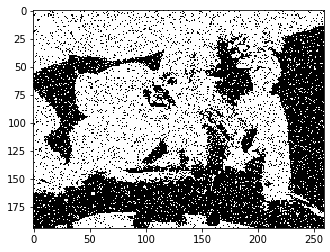

0
1
2
3
4
5
6
7
8
9
error rate before
5028.0
error rate after
1094.0


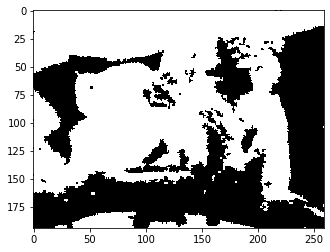

In [74]:
noise_img = np.vectorize(noise)(binary_img)
plt.imshow(noise_img, cmap="gray", interpolation="none")
plt.show()

denoise_img = denoise(noise_img, 10)

print("error rate before")
print(np.sum((binary_img != noise_img).astype(np.float)))
print("error rate after")
print(np.sum((binary_img != denoise_img).astype(np.float)))
plt.imshow(denoise_img, cmap="gray", interpolation="none")
plt.show()